# PART 1

##  Define the problem you are trying to solve and why machine learning will provide the best solution for this problem. Identify the dataset you plan to use for this project and its location.

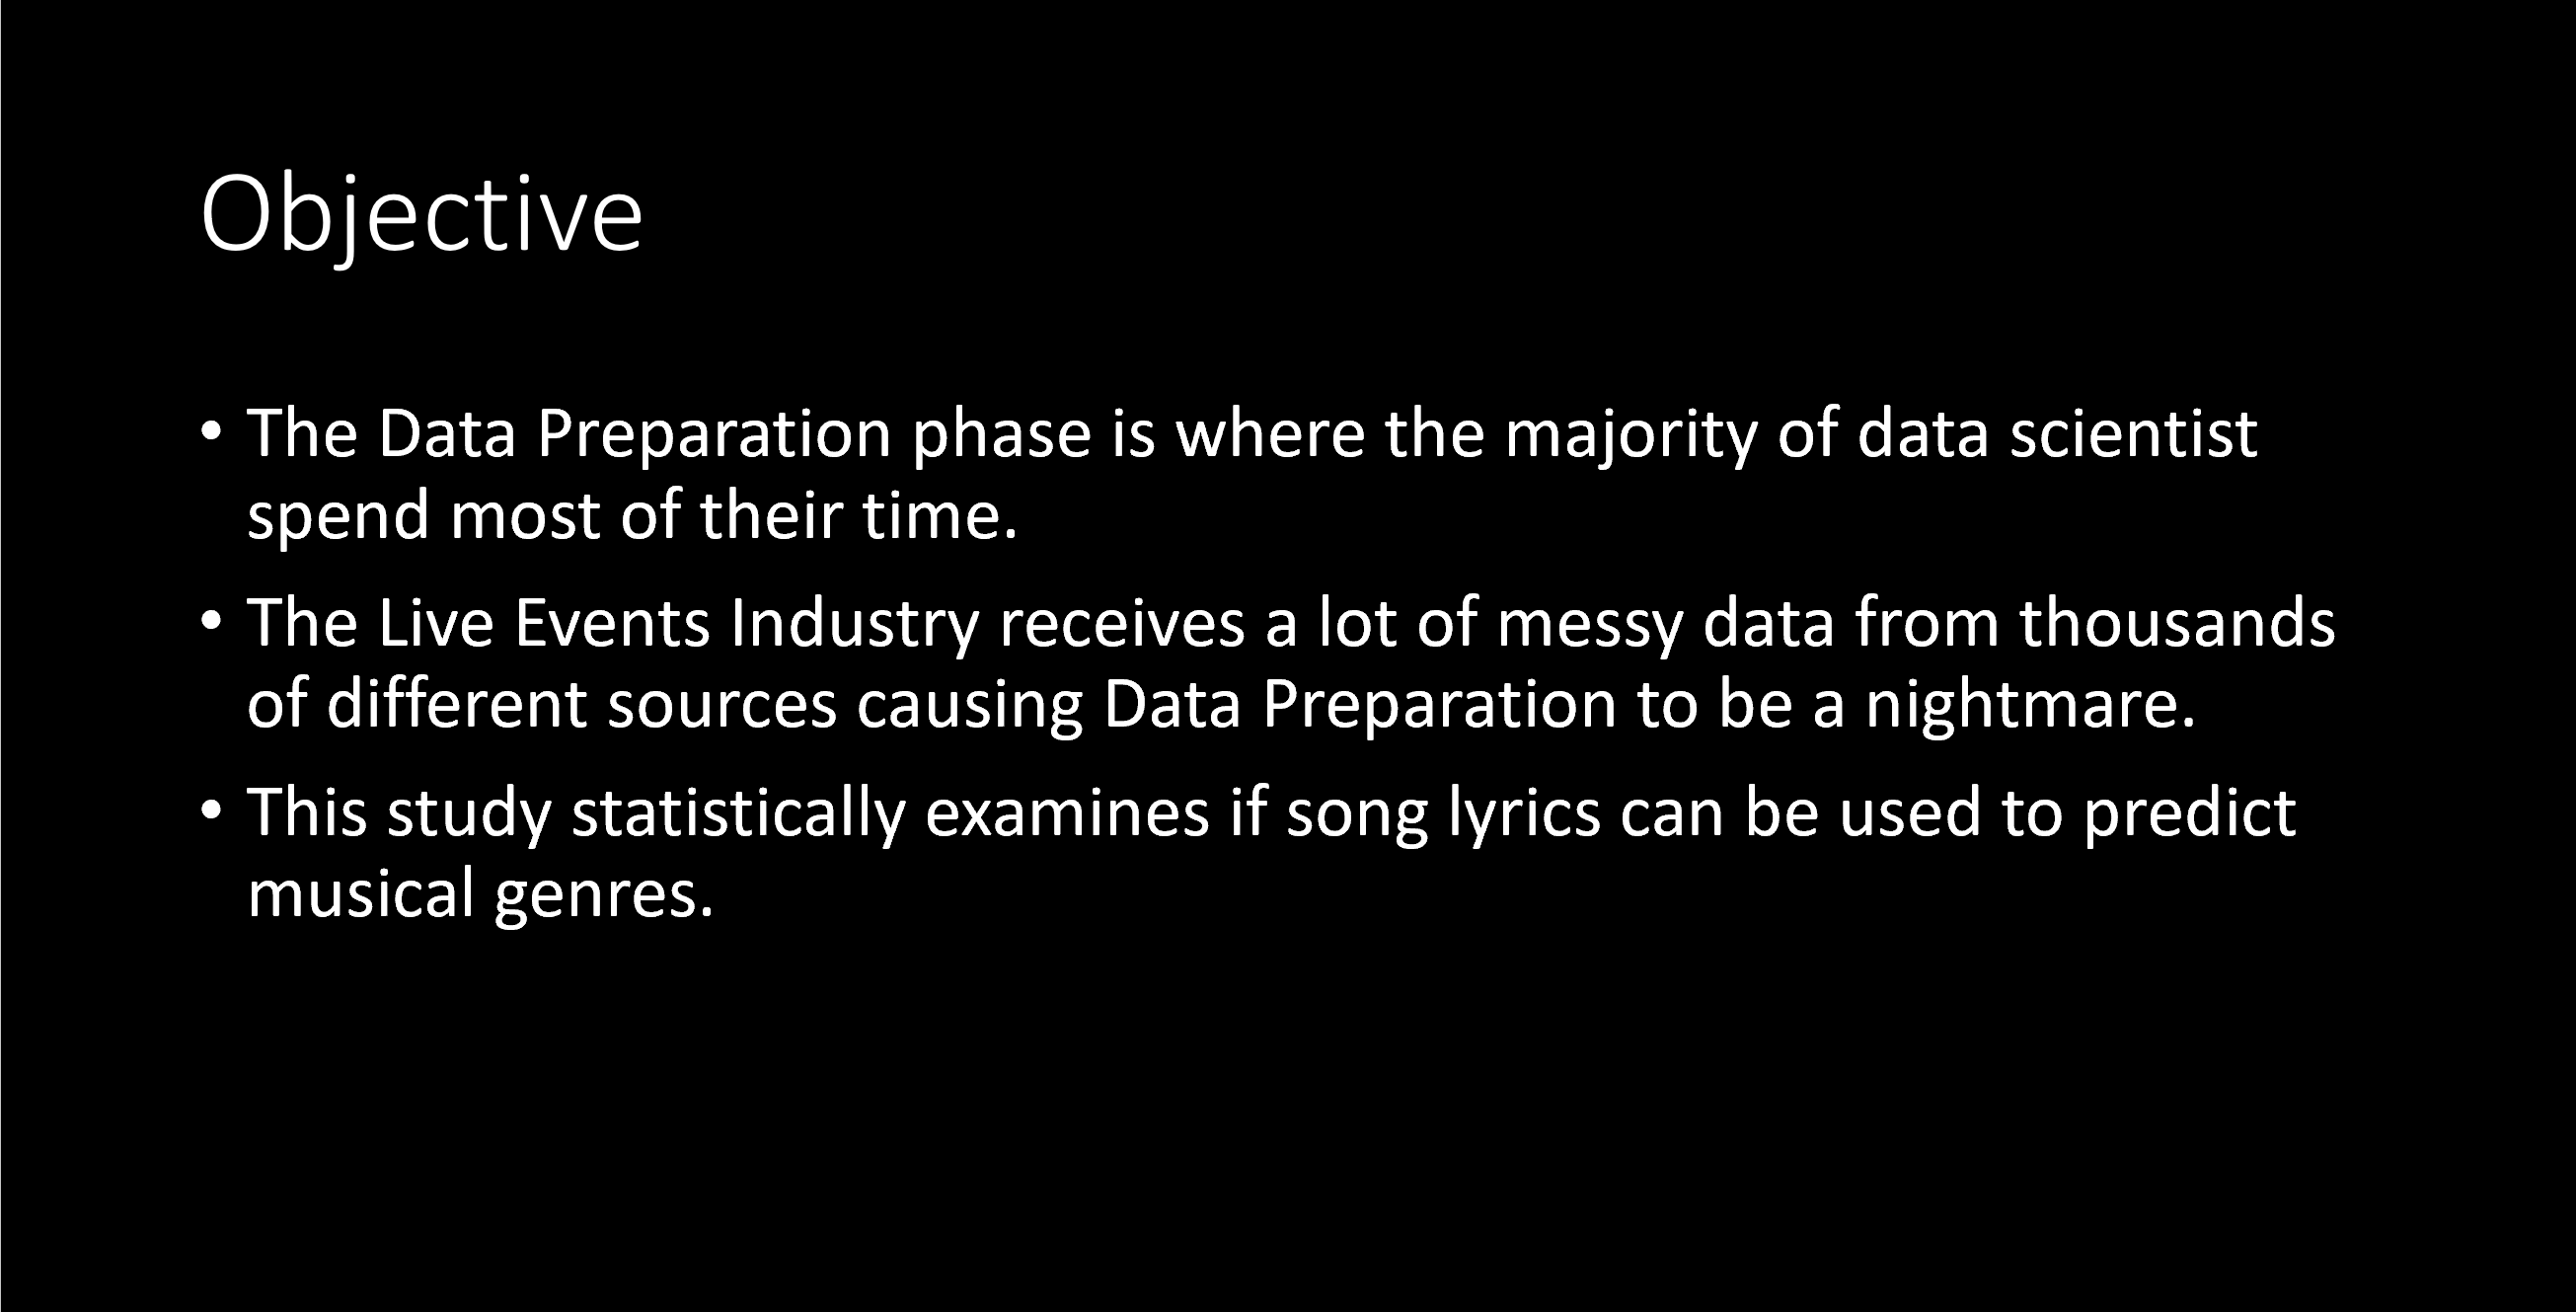

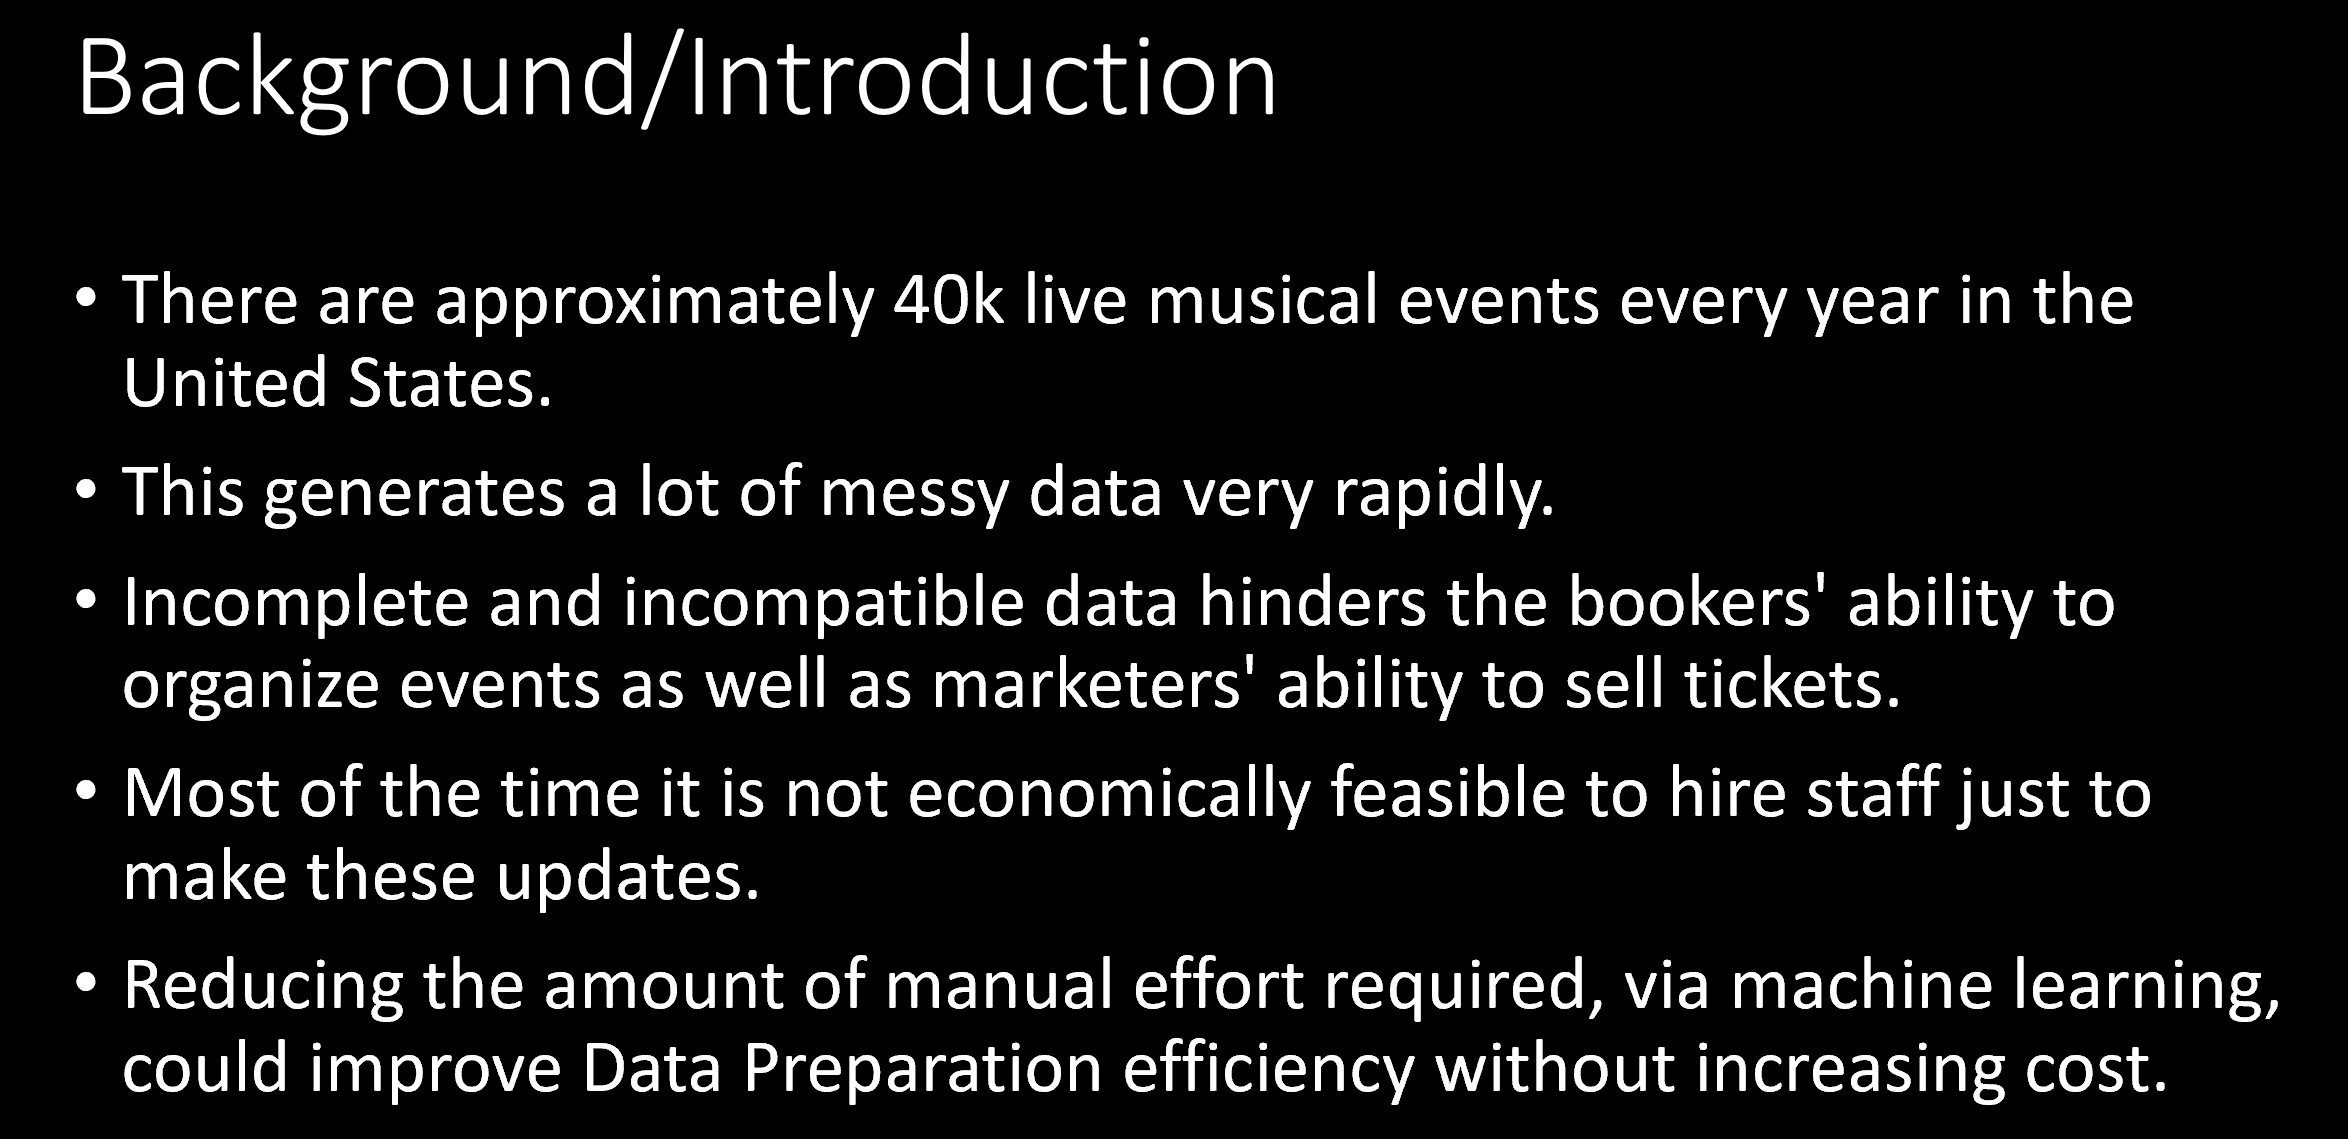

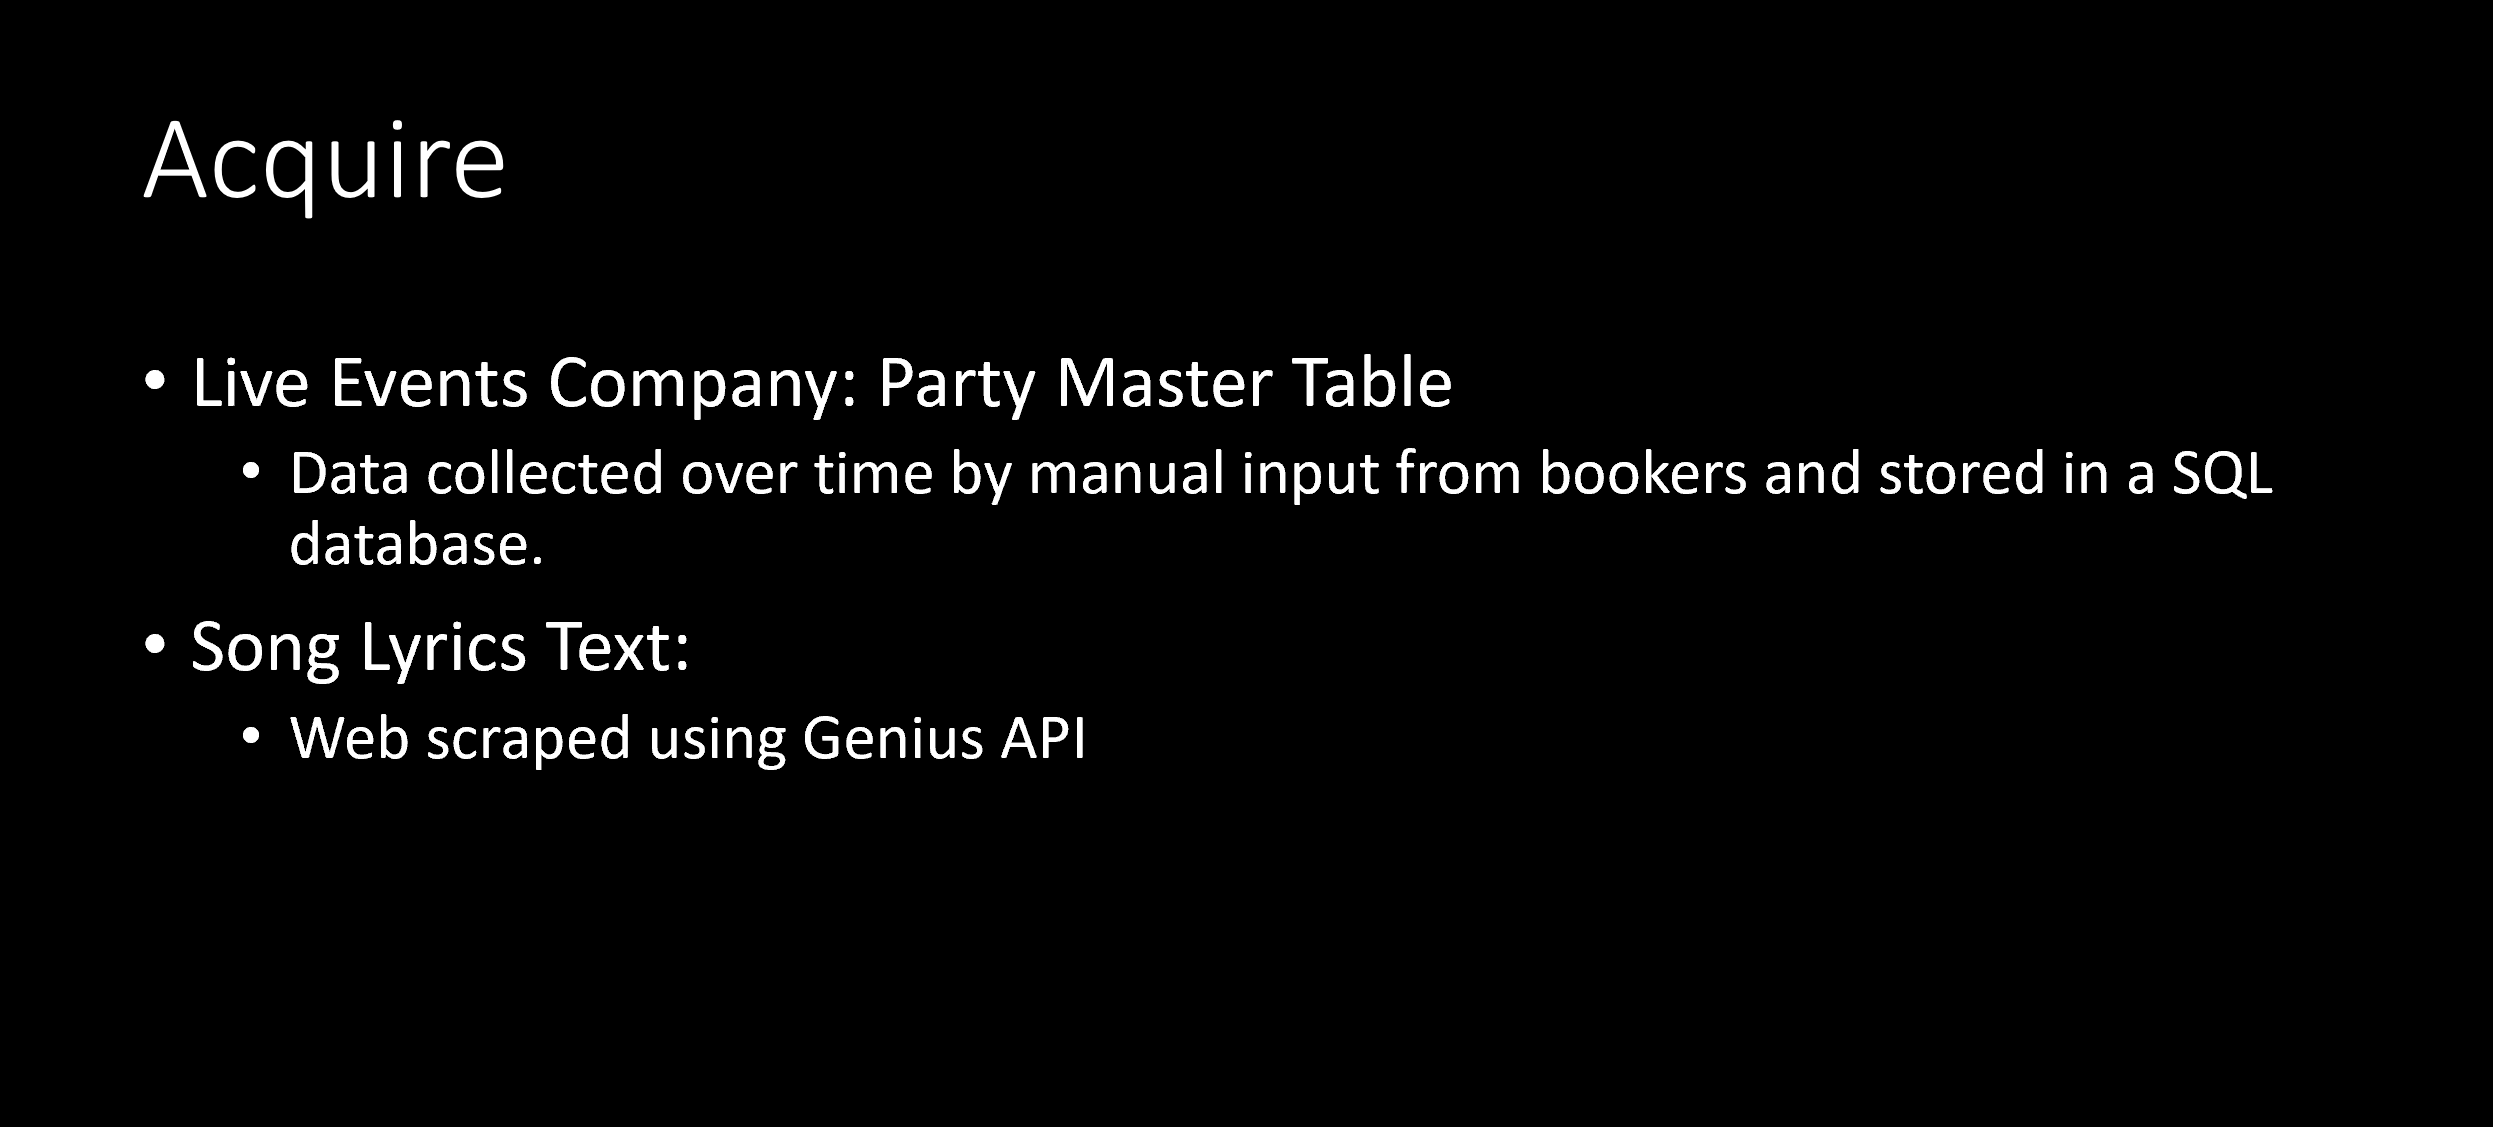

# PART 2

## Perform data exploration, data cleaning, feature engineering and selection on Jupyter Notebook or Google Colab.

In [1]:
!conda env list

# conda environments:
#
base                     C:\ProgramData\Anaconda3
PandasProfileEnv         C:\Users\PhillipRashaad\.conda\envs\PandasProfileEnv
SMOP_env                 C:\Users\PhillipRashaad\.conda\envs\SMOP_env
cupy_tut                 C:\Users\PhillipRashaad\.conda\envs\cupy_tut
datascienv               C:\Users\PhillipRashaad\.conda\envs\datascienv
flask_env             *  C:\Users\PhillipRashaad\.conda\envs\flask_env
flask_pycaret_env        C:\Users\PhillipRashaad\.conda\envs\flask_pycaret_env
keras_env                C:\Users\PhillipRashaad\.conda\envs\keras_env
pandasprofileenv         C:\Users\PhillipRashaad\.conda\envs\pandasprofileenv
pycaret_env              C:\Users\PhillipRashaad\.conda\envs\pycaret_env



In [ ]:
!python -V

In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
%matplotlib inline

In [3]:
lyric_df = pd.read_excel('02 - clean_training_data.xlsx')
print(lyric_df.shape)

lyric_df.head()

(5620, 7)


,api_artist,title,lyrics,artist,party_genre_all_ref,artist_name_check,Valid
0,Jason Aldean,1994,1994 Lyrics_x000D_\nNow girl I know you used t...,Jason Aldean,Country,True,yes
1,Jason Aldean,After You,"After You Lyrics_x000D_\nAfter you, I was chas...",Jason Aldean,Country,True,yes
2,Jason Aldean,Ainâ€™t Enough Cowboy,Ainâ€™t Enough Cowboy Lyrics_x000D_\nCowboy in...,Jason Aldean,Country,True,yes
3,Jason Aldean,Ainâ€™t No Easy Way,Ainâ€™t No Easy Way Lyrics_x000D_\nThere ain't...,Jason Aldean,Country,True,yes
4,Jason Aldean,A Little More Summertime,A Little More Summertime Lyrics_x000D_\nThey b...,Jason Aldean,Country,True,yes


In [4]:
#VIew the GEnre split
lyric_df['party_genre_all_ref'].value_counts()

R&B              1160
Rock             1140
Pop              1000
Rap/Hip-Hop       580
Country           540
International     460
Other Music       380
Electronic        360
Name: party_genre_all_ref, dtype: int64

In [5]:
#CHeck for Nan Lyrics
lyric_df['lyrics'].notna().value_counts()

True     5400
False     220
Name: lyrics, dtype: int64

In [6]:
#filter out nan lyrics rows
lyric_df = lyric_df[lyric_df['lyrics'].notna()]


lyric_df['lyrics'].notna().value_counts()

True    5400
Name: lyrics, dtype: int64

In [7]:
#VIew the GEnre split again
lyric_df['party_genre_all_ref'].value_counts()

R&B              1134
Rock             1125
Pop               997
Rap/Hip-Hop       573
Country           540
International     455
Other Music       313
Electronic        263
Name: party_genre_all_ref, dtype: int64

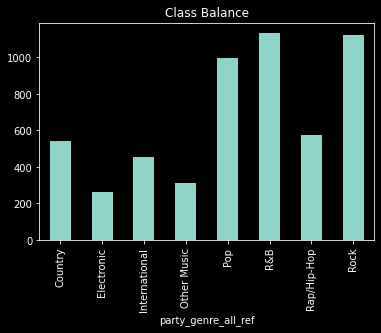

In [8]:
plt.style.use('dark_background')

lyric_df.groupby('party_genre_all_ref').lyrics.count().plot.bar( )
plt.title('Class Balance')
plt.show()

## THe first model had issues with Pop Rock & R&B so I am over sampling training data to overcome this issue

# NLP DATA CLEANING & FEATURE ENGINEERING

In [9]:
#Get string length for raw lyrics
lyric_df['char_len'] = lyric_df['lyrics'].apply(len)

lyric_df.head()

,api_artist,title,lyrics,artist,party_genre_all_ref,artist_name_check,Valid,char_len
0,Jason Aldean,1994,1994 Lyrics_x000D_\nNow girl I know you used t...,Jason Aldean,Country,True,yes,2152
1,Jason Aldean,After You,"After You Lyrics_x000D_\nAfter you, I was chas...",Jason Aldean,Country,True,yes,1796
2,Jason Aldean,Ainâ€™t Enough Cowboy,Ainâ€™t Enough Cowboy Lyrics_x000D_\nCowboy in...,Jason Aldean,Country,True,yes,1589
3,Jason Aldean,Ainâ€™t No Easy Way,Ainâ€™t No Easy Way Lyrics_x000D_\nThere ain't...,Jason Aldean,Country,True,yes,1105
4,Jason Aldean,A Little More Summertime,A Little More Summertime Lyrics_x000D_\nThey b...,Jason Aldean,Country,True,yes,1502


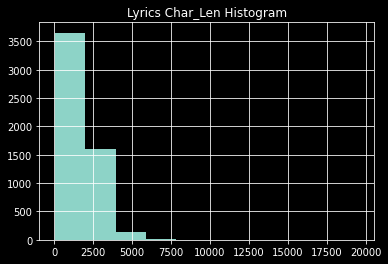

In [10]:
plt.style.use('dark_background')

lyric_df['char_len'].hist()
plt.title('Lyrics Char_Len Histogram')

plt.show()

## DATA CLEANING - Custom Lemmatizer

In [11]:
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
# Init the Wordnet Stemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PhillipRashaad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PhillipRashaad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
#Function that cleans text
def Lemmatize_Text_Cleaner(s):
    import string
    s = ' '.join(s.splitlines(keepends=True)[1:]) # Remove title from text

    #s = s.replace('\d+', '') # for digits
    s = s.replace(r'(\b\w{1,2}\b)', '') # for words
    s = s.replace('[^\w\s]', '') # for punctuation 
    
    # Tokenize: Split the sentence into words
    word_list = nltk.word_tokenize(s)
    
    #another layer to remove punc
    word_list=[word.lower() for word in word_list if word.isalpha()]
    
    #Only include words with len >= 3
    word_list=[word.lower() for word in word_list if len(word) >=2]
    
    #This part removes stop words
    stop_words = set(stopwords.words('english'))
    
    word_list = [w for w in word_list if not w.lower() in stop_words]
    
    
    #Remove for common appearing words
    #common_words = ["know" ,"love" ,"yeah", "got", "wanna", "gonna", 
                    #"see", "wan", "gon", "na", "time", "never"]
    
    #word_list = [w for w in word_list if not w.lower() in common_words]
    
    
    
    # Lemmatize list of words and join
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    
    return lemmatized_output.lower()

In [13]:
#Add column of cleaned text 
lyric_df['lem_cleaned'] = lyric_df['lyrics'].apply(Lemmatize_Text_Cleaner)
lyric_df.head()

,api_artist,title,lyrics,artist,party_genre_all_ref,artist_name_check,Valid,char_len,lem_cleaned
0,Jason Aldean,1994,1994 Lyrics_x000D_\nNow girl I know you used t...,Jason Aldean,Country,True,yes,2152,girl know used old ai floatin boat ai ridin ho...
1,Jason Aldean,After You,"After You Lyrics_x000D_\nAfter you, I was chas...",Jason Aldean,Country,True,yes,1796,chasin sunset seger song backseat kinda drove ...
2,Jason Aldean,Ainâ€™t Enough Cowboy,Ainâ€™t Enough Cowboy Lyrics_x000D_\nCowboy in...,Jason Aldean,Country,True,yes,1589,cowboy cuss fight get fed night every time wak...
3,Jason Aldean,Ainâ€™t No Easy Way,Ainâ€™t No Easy Way Lyrics_x000D_\nThere ain't...,Jason Aldean,Country,True,yes,1105,ai easy hear thing need go say baby take ai ea...
4,Jason Aldean,A Little More Summertime,A Little More Summertime Lyrics_x000D_\nThey b...,Jason Aldean,Country,True,yes,1502,boarding water ai nobody hanging another grey ...


In [14]:
print(lyric_df['lyrics'].iloc[0])

1994 Lyrics_x000D_
Now girl I know you used to the same old same_x000D_
But we ain't floatin' that boat, no we ain't ridin' that train_x000D_
Hop on my rocket ship and let's get outta here_x000D_
Let me put a little shimmer in your atmosphere_x000D_
Now let's get outta this town, outta this club_x000D_
Girl whatever you're sippin' I'ma mix it up_x000D_
Take a few tick tocks off of your clock_x000D_
Put a little Third Rock in your hip-hop_x000D_
I got that_x000D_
1994, Joe Diffie comin' out my radio_x000D_
I'm just a country boy with a farmer's tan_x000D_
So help me girl I'll be your pickup man_x000D_
How 'bout a night to remember and a fifth of Goose_x000D_
'Bout to bust out my honky tonk attitude_x000D_
A little feel good you ain't never felt before_x000D_
I'm talkin' 1994_x000D_
Hey Joe, Joe, Joe Diffie_x000D_
Joe, Joe, Joe Diffie_x000D_
Joe, Joe, Joe Diffie_x000D_
Girl don't you worry, now your ship just came in_x000D_
So go on tell your mama, tell all your friends_x000D_
That your 

In [15]:
print(lyric_df['lem_cleaned'].iloc[0])

girl know used old ai floatin boat ai ridin hop rocket ship let get outta let put little shimmer let get outta town outta girl whatever sippin mix take tick tocks put little third rock got joe diffie comin country boy farmer help girl pickup night remember fifth bust honky tonk little feel good ai never felt talkin hey joe joe joe joe joe joe joe joe joe girl worry ship came go tell mama tell new favorite color john deere hop truck aka time joe diffie comin country boy farmer help girl pickup night remember fifth bust honky tonk little feel good ai never felt talkin hey joe joe joe joe joe joe joe joe joe baby lookin good let take baby let go holler hey joe come teach u joe diffie comin country boy farmer help girl pickup night remember fifth bust honky tonk little feel good ai never felt talkin hey joe joe joe joe joe joe joe joe joe real joe diffie please stand


### CREATE lem_char_len GET CHARACTER COUNT OF CLEAN TEXT INSTEAD OF RAW TEXT

In [16]:
#Get string length for raw lyrics
lyric_df['lem_char_len'] = lyric_df['lem_cleaned'].apply(len)

lyric_df.head()

,api_artist,title,lyrics,artist,party_genre_all_ref,artist_name_check,Valid,char_len,lem_cleaned,lem_char_len
0,Jason Aldean,1994,1994 Lyrics_x000D_\nNow girl I know you used t...,Jason Aldean,Country,True,yes,2152,girl know used old ai floatin boat ai ridin ho...,875
1,Jason Aldean,After You,"After You Lyrics_x000D_\nAfter you, I was chas...",Jason Aldean,Country,True,yes,1796,chasin sunset seger song backseat kinda drove ...,615
2,Jason Aldean,Ainâ€™t Enough Cowboy,Ainâ€™t Enough Cowboy Lyrics_x000D_\nCowboy in...,Jason Aldean,Country,True,yes,1589,cowboy cuss fight get fed night every time wak...,538
3,Jason Aldean,Ainâ€™t No Easy Way,Ainâ€™t No Easy Way Lyrics_x000D_\nThere ain't...,Jason Aldean,Country,True,yes,1105,ai easy hear thing need go say baby take ai ea...,307
4,Jason Aldean,A Little More Summertime,A Little More Summertime Lyrics_x000D_\nThey b...,Jason Aldean,Country,True,yes,1502,boarding water ai nobody hanging another grey ...,569


In [17]:
#save to csv
#lyric_df.to_csv('03 - NLP_transformed_training_data.csv', index=False)

## Char_len STATISTICS

In [18]:
lyric_df['char_len'].describe()

count     5400.000000
mean      1763.102963
std       1004.631694
min         18.000000
25%       1187.750000
50%       1634.500000
75%       2147.250000
max      19576.000000
Name: char_len, dtype: float64

In [19]:
lyric_df['lem_char_len'].describe()

count     5400.000000
mean       627.169074
std        455.933205
min          0.000000
25%        373.000000
50%        550.000000
75%        767.000000
max      10085.000000
Name: lem_char_len, dtype: float64

# RE-RUN STARTS HERE!!

## SET CHAR_LEN MIN

In [20]:
#this variable determins min for text char_len
char_len_min = 475

char_len_min

475

In [21]:
#Filter small Char_Len into new df
bad_data_df = lyric_df[lyric_df['lem_char_len']<char_len_min]

print(bad_data_df.shape)

bad_data_df.head()

(2073, 10)


,api_artist,title,lyrics,artist,party_genre_all_ref,artist_name_check,Valid,char_len,lem_cleaned,lem_char_len
3,Jason Aldean,Ainâ€™t No Easy Way,Ainâ€™t No Easy Way Lyrics_x000D_\nThere ain't...,Jason Aldean,Country,True,yes,1105,ai easy hear thing need go say baby take ai ea...,307
10,Jason Aldean,Asphalt Cowboy,Asphalt Cowboy Lyrics_x000D_\nThe sun has open...,Jason Aldean,Country,True,yes,1348,sun opened wan na leave lonesome climbin back ...,378
37,Chris Janson,Eyes for Nobody,Eyes for Nobody Lyrics_x000D_\nFor a guy like ...,Chris Janson,Country,True,yes,1275,guy like take find something like found start ...,460
41,Phil Vassar,American Child,"American Child LyricsI was ten, I was thin, I ...",Phil Vassar,Country,True,yes,1137,secondhand glove dirt nowhere ever figure kid ...,466
55,Phil Vassar,Erase,"Erase LyricsBad move, baby I let you in_x000D_...",Phil Vassar,Country,True,yes,686,tattoo ca wash permanent try let go try still ...,185


In [22]:
bad_data_df['party_genre_all_ref'].value_counts()

Rock             639
R&B              435
Pop              241
Electronic       190
International    170
Other Music      170
Country          148
Rap/Hip-Hop       80
Name: party_genre_all_ref, dtype: int64

In [23]:
#Filter out small Char_Len from sample
good_data_df = lyric_df[lyric_df['lem_char_len']>char_len_min]

print(good_data_df.shape)

good_data_df.head()

(3321, 10)


,api_artist,title,lyrics,artist,party_genre_all_ref,artist_name_check,Valid,char_len,lem_cleaned,lem_char_len
0,Jason Aldean,1994,1994 Lyrics_x000D_\nNow girl I know you used t...,Jason Aldean,Country,True,yes,2152,girl know used old ai floatin boat ai ridin ho...,875
1,Jason Aldean,After You,"After You Lyrics_x000D_\nAfter you, I was chas...",Jason Aldean,Country,True,yes,1796,chasin sunset seger song backseat kinda drove ...,615
2,Jason Aldean,Ainâ€™t Enough Cowboy,Ainâ€™t Enough Cowboy Lyrics_x000D_\nCowboy in...,Jason Aldean,Country,True,yes,1589,cowboy cuss fight get fed night every time wak...,538
4,Jason Aldean,A Little More Summertime,A Little More Summertime Lyrics_x000D_\nThey b...,Jason Aldean,Country,True,yes,1502,boarding water ai nobody hanging another grey ...,569
5,Jason Aldean,All Out Of Beer,All Out Of Beer Lyrics_x000D_\nIf you'd got he...,Jason Aldean,Country,True,yes,1553,got buzz kicked told go never let crashed couc...,486


In [24]:
good_data_df['party_genre_all_ref'].value_counts()

Pop              756
R&B              696
Rap/Hip-Hop      492
Rock             485
Country          391
International    285
Other Music      143
Electronic        73
Name: party_genre_all_ref, dtype: int64

## NLP EDA & VISUALIZATIONS

In [25]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data, title):
    text = data.values 

    wordcloud = WordCloud(width=400, height=330, max_words=100,colormap="Dark2").generate(str(text))

    plt.figure( figsize=(10,10), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title('{}\n'.join(wrap(title,60)),fontsize=13)#.format(topic)
    plt.show()
    #plt.savefig('WordCloud')

In [26]:
genre_lst = lyric_df['party_genre_all_ref'].unique()

genre_lst

array(['Country', 'Electronic', 'International', 'Rap/Hip-Hop',
       'Other Music', 'R&B', 'Pop', 'Rock'], dtype=object)

Country


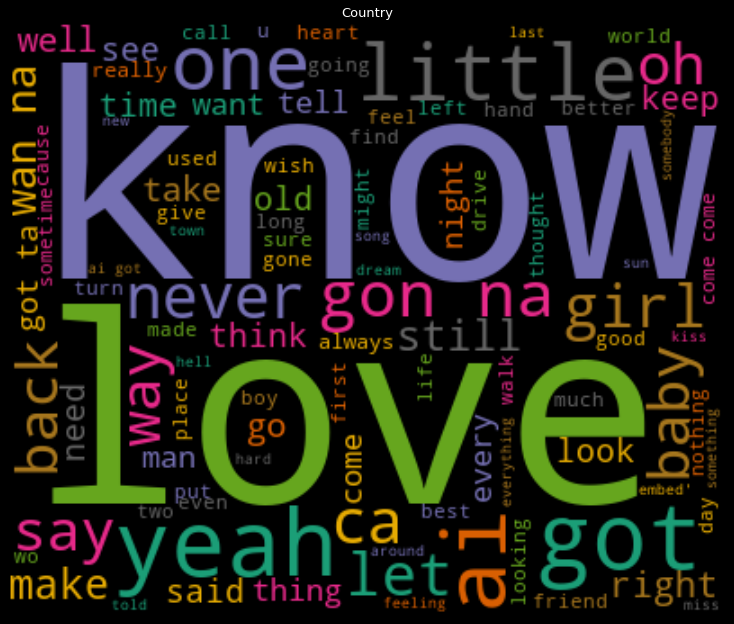

Electronic


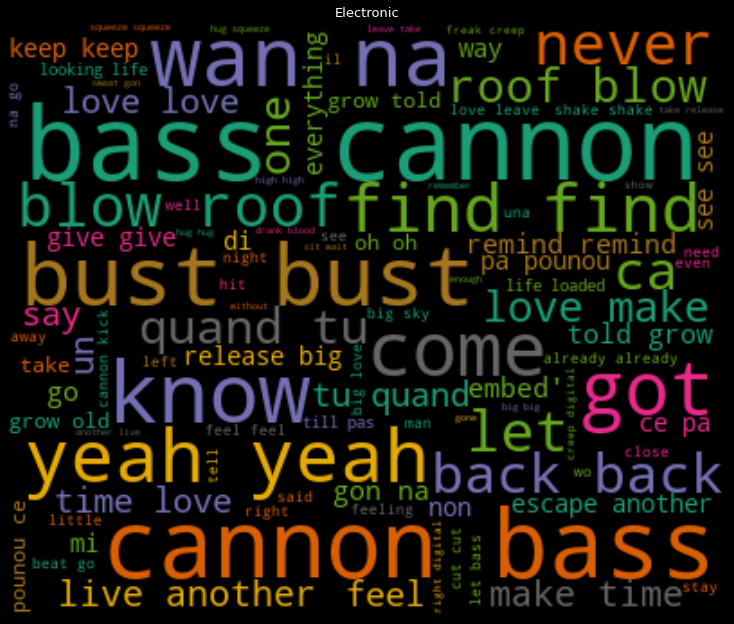

International


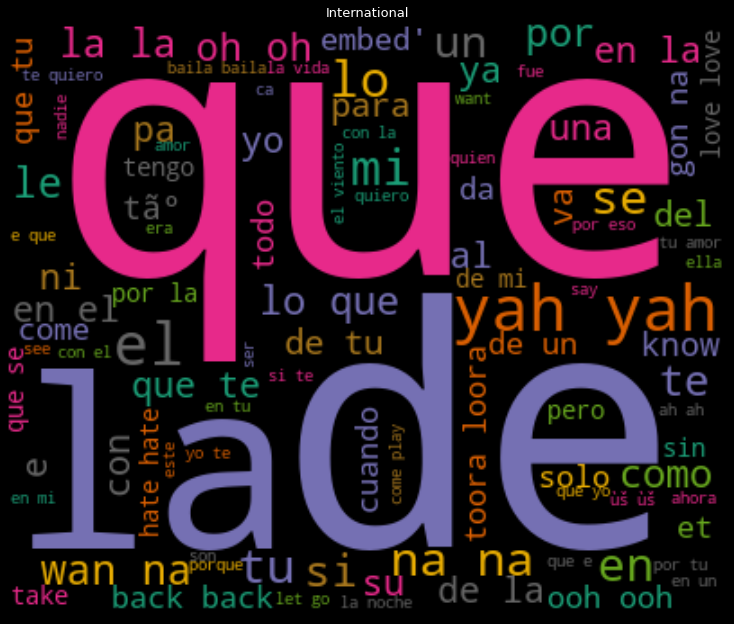

Rap/Hip-Hop


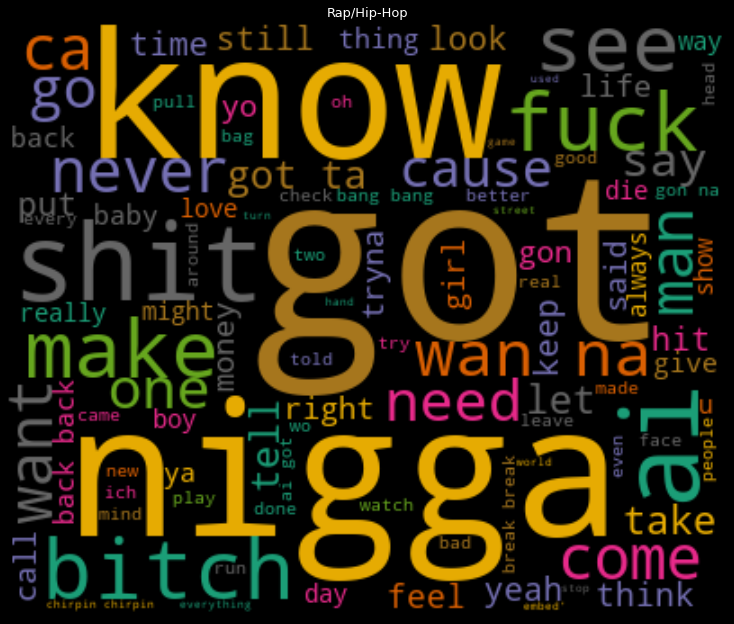

Other Music


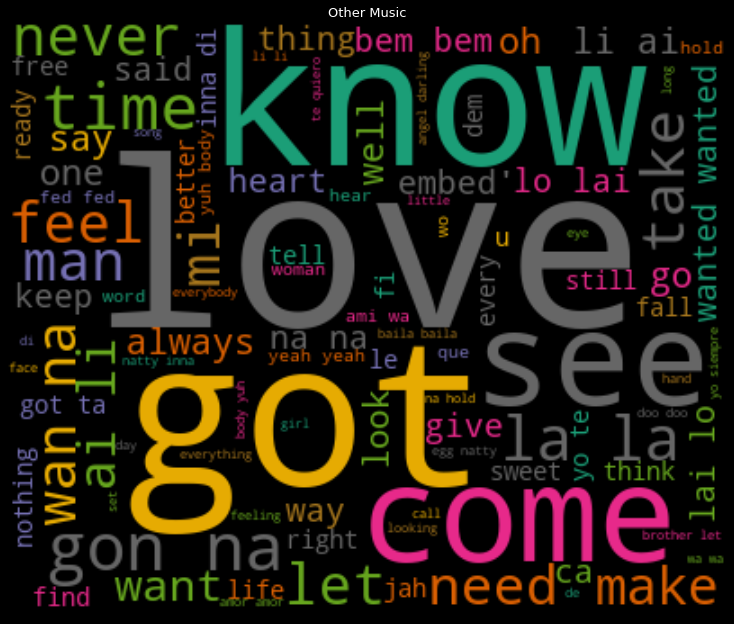

R&B


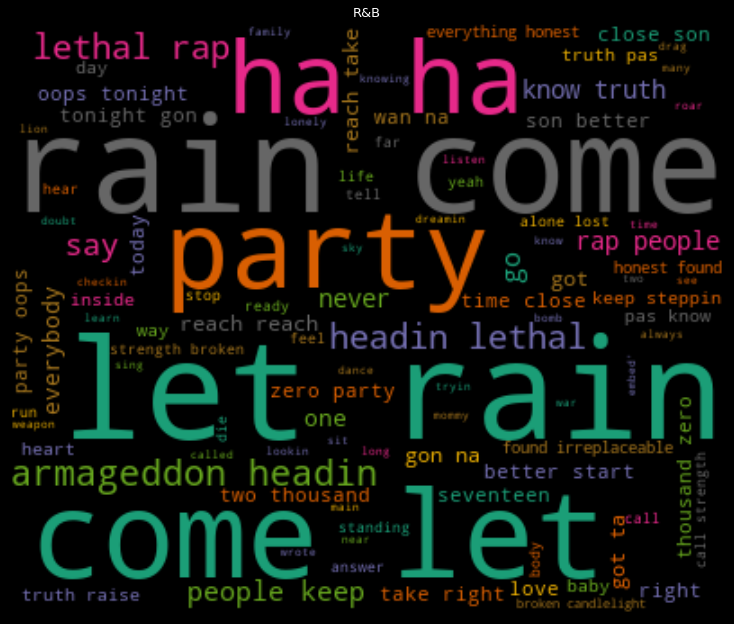

Pop


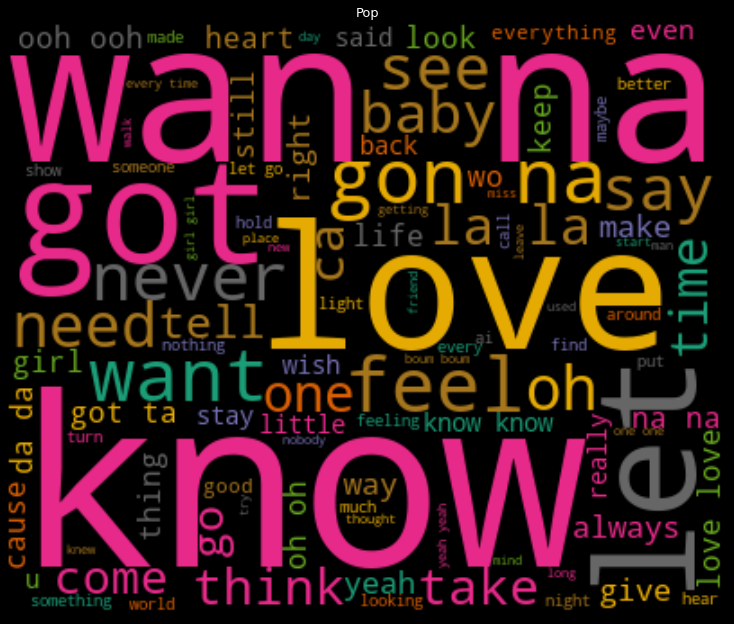

Rock


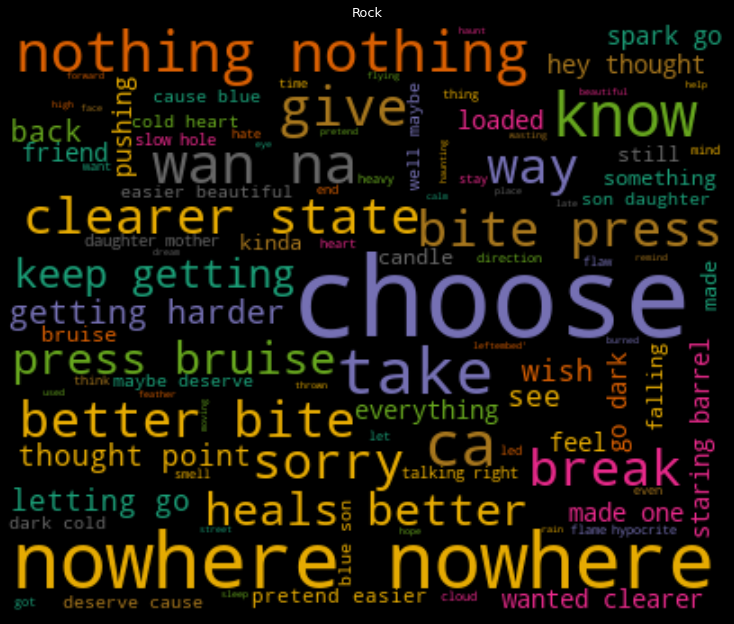

In [27]:
for gen in genre_lst:
    print(gen)
    generate_wordcloud(lyric_df['lem_cleaned'][lyric_df['party_genre_all_ref']==gen], gen) 
    

# PART 3

## Split data into testing, training, and validation; select training algorithm(s) and metrics to train the model and evaluate its performance. Save the project as ipynb and. pkl in GitHub.

# MODEL BUILDING, TRAINING, & EVALUATION

In [28]:
def NLP_Model_Builder(input_df, test_sz=.25):
    
    df = input_df.copy()
    
    #Dict to capture finished elements of model building function
    output_dict = {}
    
    from sklearn.preprocessing import LabelEncoder
    # integer encode
    #Initialize object
    le = LabelEncoder()
    
    #
    int_encoded = le.fit_transform(df['party_genre_all_ref'].to_numpy())

    df['class']= int_encoded

    #Capture LabelEncoder data
    output_dict['LabelEncoder'] = le
    
    
    print('CHAR_LEN_MIN > ', char_len_min)
    print('-'*20)
    print(df['char_len'].describe(), '\n')
    print('INPUT DATA: ', df.shape, '\n')
    
    print('STEP 1. TRAIN TEST SPLIT\n')
    #STEP 1. TRAIN TEST SPLIT
    # this block is to split the dataset into training and testing set 
    X = df['lem_cleaned']
    Y = df['class']
    
    #Capture unsplit data
    output_dict['X'] = X
    output_dict['Y'] = Y
    
    #split data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_sz, random_state=11)
    
    #Capture training data
    output_dict['X_train'] = X_train
    output_dict['y_train'] = y_train
    
    #Capture test data
    output_dict['X_test'] = X_train
    output_dict['y_test'] = y_train
    
    
    
    print('TRAIN DATASET')
    print(X_train.shape)
    print(y_train.shape)
    print('\nCLASS BALANCE\n', y_train.value_counts(), '\n')

    print('TEST DATASET')
    print(X_test.shape)
    print(y_test.shape)
    print('\nCLASS BALANCE\n',y_test.value_counts(), '\n')

    
    print('STEP 2. BUILD MODEL WITH PIPELINE\n')
    #STEP 2. BUILD MODEL WITH PIPELINE
    tune_vectorizer = TfidfVectorizer(min_df= 6, stop_words=None, sublinear_tf=True, norm='l2', ngram_range=(1, 4))

    # instead of doing these steps one at a time, we can use a pipeline to complete them all at once
    tune_pipeline = Pipeline([('vect', tune_vectorizer),
                         #('chi',  SelectKBest(chi2, k=800)), #reducing dim hurt acc
                         ('clf', RandomForestClassifier())])
    
    
    print('STEP 3. TRAIN THE MODEL\n')
    #STEP 3. TRAIN THE MODEL
    # fitting our model and save it in a pickle for later use
    tune_rf_model = tune_pipeline.fit(X_train, y_train)
    
    #Capture trained model
    output_dict['model'] = tune_rf_model
    
    
    print('STEP 4. USE THE MODEL TO MAKE PREDICTIONS ON TEST DATA')
    #STEP 4. USE THE MODEL TO MAKE PREDICTIONS ON TEST DATA
    tune_predictions = tune_rf_model.predict(X_test)
    
    print('TOTAL PREDICTIONS: ', len(tune_predictions), '\n')
    
    #Capture validation predictions
    output_dict['val_predictions'] = tune_predictions
    
    ytest = np.array(y_test)

    
    print('STEP 5. EVALUATE MODEL PEFORMANCE USING PREDICTIONS\n')
    #STEP 5. EVALUATE MODEL PEFORMANCE USING PREDICTIONS
    
    #5B. CONFUSION MATRIX
    # invert first example
    inv_classes = le.inverse_transform(tune_rf_model.classes_)
    print(inv_classes)
    
    
    #Capture validation predictions
    output_dict['inv_classes'] = inv_classes
    
    # confusion matrix and classification report(precision, recall, F1-score)
    tune_cr = classification_report(ytest, tune_predictions, output_dict=True, target_names=inv_classes )
    
    #5A. CLASSIFICATION REPORT
    import seaborn as sns
    sns.heatmap(pd.DataFrame(tune_cr).iloc[:-1, :].T, annot=True ).set(title='RandomForestClassifier Tuned Model\nClassification Report')
    

    
    
    
    tune_cm = confusion_matrix(ytest, tune_predictions, labels=tune_rf_model.classes_)

    from sklearn.metrics import ConfusionMatrixDisplay

    tune_disp = ConfusionMatrixDisplay(confusion_matrix=tune_cm, display_labels=inv_classes)

    fig, ax = plt.subplots(figsize=(10,10))
    tune_disp.plot(ax=ax, xticks_rotation='vertical')
    plt.title('RandomForestClassifier Tuned Model\nConfusion Matrix')
    plt.show()
    
    #GET ACCURACY SCORE
    from sklearn.metrics import accuracy_score

    accuracy = accuracy_score(ytest, tune_predictions)
    print('MODEL ACCURACY: {}%'.format(round(accuracy*100, 2)))
    
    #Capture validation predictions
    output_dict['val_accuracy'] = accuracy
 
    
    print('DONE!')
    
    
    return output_dict

In [29]:
#view table to use for modeling
good_data_df.head()

,api_artist,title,lyrics,artist,party_genre_all_ref,artist_name_check,Valid,char_len,lem_cleaned,lem_char_len
0,Jason Aldean,1994,1994 Lyrics_x000D_\nNow girl I know you used t...,Jason Aldean,Country,True,yes,2152,girl know used old ai floatin boat ai ridin ho...,875
1,Jason Aldean,After You,"After You Lyrics_x000D_\nAfter you, I was chas...",Jason Aldean,Country,True,yes,1796,chasin sunset seger song backseat kinda drove ...,615
2,Jason Aldean,Ainâ€™t Enough Cowboy,Ainâ€™t Enough Cowboy Lyrics_x000D_\nCowboy in...,Jason Aldean,Country,True,yes,1589,cowboy cuss fight get fed night every time wak...,538
4,Jason Aldean,A Little More Summertime,A Little More Summertime Lyrics_x000D_\nThey b...,Jason Aldean,Country,True,yes,1502,boarding water ai nobody hanging another grey ...,569
5,Jason Aldean,All Out Of Beer,All Out Of Beer Lyrics_x000D_\nIf you'd got he...,Jason Aldean,Country,True,yes,1553,got buzz kicked told go never let crashed couc...,486


## LabelEncoder

In [30]:
#redo lable encoder
from sklearn.preprocessing import LabelEncoder
# integer encode
#Initialize object
le = LabelEncoder()

#
int_encoded = le.fit_transform(good_data_df['party_genre_all_ref'].to_numpy())

good_data_df['class']= int_encoded

print(good_data_df.shape)

good_data_df['class'].value_counts()

(3321, 11)


C:\Users\PhillipRashaad\AppData\Local\Temp\ipykernel_143768\4286506057.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_data_df['class']= int_encoded


4    756
5    696
6    492
7    485
0    391
2    285
3    143
1     73
Name: class, dtype: int64

In [31]:
#holdout set
train_df, holdout_df = train_test_split(good_data_df, test_size=0.1, random_state=11)

print(train_df.shape)

train_df['party_genre_all_ref'].value_counts(dropna=False)

(2988, 11)


Pop              677
R&B              631
Rock             444
Rap/Hip-Hop      435
Country          351
International    260
Other Music      127
Electronic        63
Name: party_genre_all_ref, dtype: int64

# RUN MODEL BUILDER

CHAR_LEN_MIN >  475
--------------------
count     2988.000000
mean      2186.356426
std        908.947531
min        829.000000
25%       1656.000000
50%       1986.000000
75%       2440.250000
max      17567.000000
Name: char_len, dtype: float64 

INPUT DATA:  (2988, 11) 

STEP 1. TRAIN TEST SPLIT

TRAIN DATASET
(2689,)
(2689,)

CLASS BALANCE
 4    601
5    574
7    405
6    394
0    320
2    218
3    117
1     60
Name: class, dtype: int64 

TEST DATASET
(299,)
(299,)

CLASS BALANCE
 4    76
5    57
2    42
6    41
7    39
0    31
3    10
1     3
Name: class, dtype: int64 

STEP 2. BUILD MODEL WITH PIPELINE

STEP 3. TRAIN THE MODEL

STEP 4. USE THE MODEL TO MAKE PREDICTIONS ON TEST DATA
TOTAL PREDICTIONS:  299 

STEP 5. EVALUATE MODEL PEFORMANCE USING PREDICTIONS

['Country' 'Electronic' 'International' 'Other Music' 'Pop' 'R&B'
 'Rap/Hip-Hop' 'Rock']


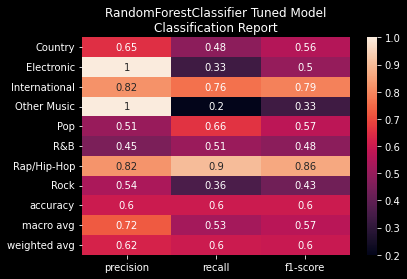

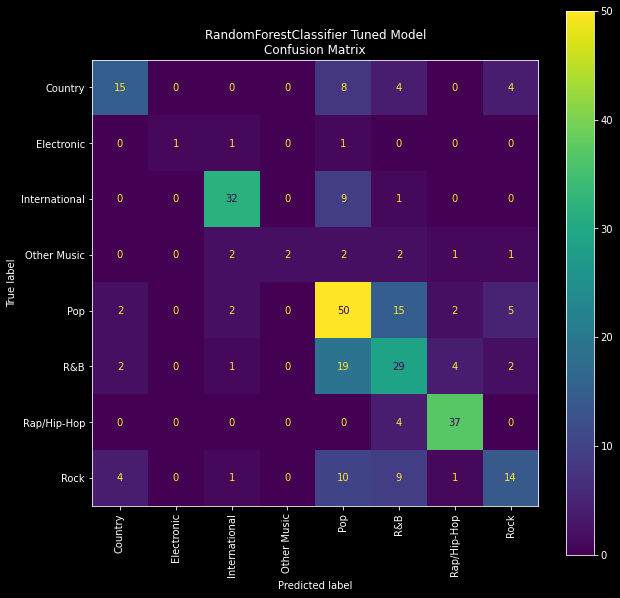

MODEL ACCURACY: 60.2%
DONE!


In [32]:
final_nlp_dict = NLP_Model_Builder(train_df, .1)

# DROP GENRES ELECTRONIC & OTHER MUSIC

In [33]:
good_data_df['party_genre_all_ref'].value_counts()

Pop              756
R&B              696
Rap/Hip-Hop      492
Rock             485
Country          391
International    285
Other Music      143
Electronic        73
Name: party_genre_all_ref, dtype: int64

In [34]:
filt_union_df = good_data_df[(good_data_df['party_genre_all_ref']!='Other Music') & (good_data_df['party_genre_all_ref']!='Electronic')].copy()

print(filt_union_df.shape)

filt_union_df['party_genre_all_ref'].value_counts()

(3105, 11)


Pop              756
R&B              696
Rap/Hip-Hop      492
Rock             485
Country          391
International    285
Name: party_genre_all_ref, dtype: int64

In [35]:
#redo lable encoder
from sklearn.preprocessing import LabelEncoder
# integer encode
#Initialize object
le = LabelEncoder()

#
int_encoded = le.fit_transform(filt_union_df['party_genre_all_ref'].to_numpy())

filt_union_df['class']= int_encoded

print(filt_union_df.shape)

filt_union_df['class'].value_counts()

(3105, 11)


2    756
3    696
4    492
5    485
0    391
1    285
Name: class, dtype: int64

In [36]:
#holdout set
filt_train_df, filt_holdout_df = train_test_split(filt_union_df, test_size=0.1, random_state=11)

print(filt_train_df.shape)

filt_train_df['party_genre_all_ref'].value_counts()

(2794, 11)


Pop              670
R&B              637
Rap/Hip-Hop      440
Rock             440
Country          350
International    257
Name: party_genre_all_ref, dtype: int64

CHAR_LEN_MIN >  475
--------------------
count     2794.000000
mean      2218.927702
std       1053.988803
min        829.000000
25%       1654.000000
50%       1999.500000
75%       2453.000000
max      19576.000000
Name: char_len, dtype: float64 

INPUT DATA:  (2794, 11) 

STEP 1. TRAIN TEST SPLIT

TRAIN DATASET
(2514,)
(2514,)

CLASS BALANCE
 2    599
3    565
5    403
4    400
0    320
1    227
Name: class, dtype: int64 

TEST DATASET
(280,)
(280,)

CLASS BALANCE
 3    72
2    71
4    40
5    37
0    30
1    30
Name: class, dtype: int64 

STEP 2. BUILD MODEL WITH PIPELINE

STEP 3. TRAIN THE MODEL

STEP 4. USE THE MODEL TO MAKE PREDICTIONS ON TEST DATA
TOTAL PREDICTIONS:  280 

STEP 5. EVALUATE MODEL PEFORMANCE USING PREDICTIONS

['Country' 'International' 'Pop' 'R&B' 'Rap/Hip-Hop' 'Rock']


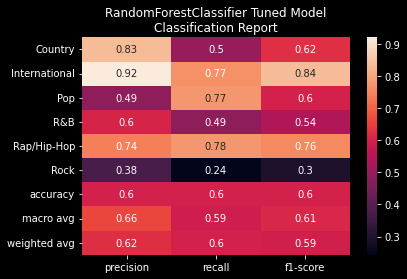

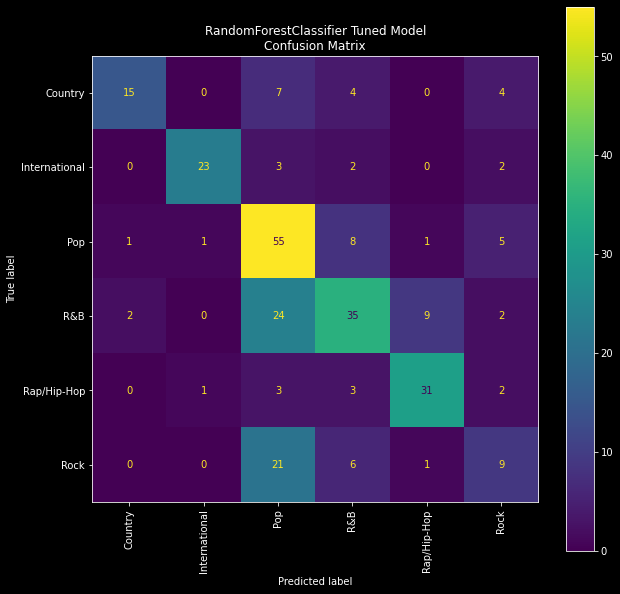

MODEL ACCURACY: 60.0%
DONE!


In [37]:
filt_final_nlp_dict = NLP_Model_Builder(filt_train_df, .1)

## CONCLUSION: More training data needs to be added for the problematic genres!

In [38]:
filt_nlp_model = filt_final_nlp_dict['model']

# FINALIZE MODEL BY TRAINING MODEL USING TRAIN + VALIDATION DATA

In [39]:
#find corresponding keys to finish training moel
filt_final_nlp_dict.keys()

dict_keys(['LabelEncoder', 'X', 'Y', 'X_train', 'y_train', 'X_test', 'y_test', 'model', 'val_predictions', 'inv_classes', 'val_accuracy'])

In [40]:
#Train model on both TRAIN & Validation data
filt_nlp_model = filt_nlp_model.fit(filt_final_nlp_dict['X'], filt_final_nlp_dict['Y'])
filt_nlp_model

Pipeline(steps=[('vect',
                 TfidfVectorizer(min_df=6, ngram_range=(1, 4),
                                 sublinear_tf=True)),
                ('clf', RandomForestClassifier())])

In [41]:
print(filt_holdout_df.shape)

filt_holdout_df.head()

(311, 11)


,api_artist,title,lyrics,artist,party_genre_all_ref,artist_name_check,Valid,char_len,lem_cleaned,lem_char_len,class
4584,Karmin,Hello,"Hello Lyrics_x000D_\nI'ma do it, do it like I ...",Karmin,Pop,True,yes,3145,like wan na gon know like ai never known bring...,1446,2
1504,Prince and the Revolution,1999 (Rosie & Doug E. in a Deep House),"1999 LyricsWho is it? _x000D_\nAre you ready,...",The Revolution,R&B,False,yes,3477,ready came party scatting piano gon take thang...,1310,3
917,Gaelic Storm,Cyclone McClusky,Cyclone McClusky LyricsTwinkling lights come i...,Gaelic Storm,International,True,yes,1336,listen sound scream fear guide u barker shout ...,522,1
4754,Maggie Rogers,Past Life,"Past Life Lyrics_x000D_\nOh, I could feel the ...",Maggie Rogers,Pop,True,yes,1195,oh could feel change felt oh could feel change...,512,2
1865,Taylor Swift,22 (Taylorâ€™s Version),22 Lyrics_x000D_\nIt feels like a perfect nig...,Taylor Swift,Pop,True,yes,2497,feel like perfect dress like make fun feel lik...,776,2


In [42]:
filt_holdout_df['predictions'] = filt_nlp_model.predict(filt_holdout_df['lem_cleaned'])

print(filt_holdout_df.shape)

filt_holdout_df.head()

(311, 12)


,api_artist,title,lyrics,artist,party_genre_all_ref,artist_name_check,Valid,char_len,lem_cleaned,lem_char_len,class,predictions
4584,Karmin,Hello,"Hello Lyrics_x000D_\nI'ma do it, do it like I ...",Karmin,Pop,True,yes,3145,like wan na gon know like ai never known bring...,1446,2,4
1504,Prince and the Revolution,1999 (Rosie & Doug E. in a Deep House),"1999 LyricsWho is it? _x000D_\nAre you ready,...",The Revolution,R&B,False,yes,3477,ready came party scatting piano gon take thang...,1310,3,4
917,Gaelic Storm,Cyclone McClusky,Cyclone McClusky LyricsTwinkling lights come i...,Gaelic Storm,International,True,yes,1336,listen sound scream fear guide u barker shout ...,522,1,5
4754,Maggie Rogers,Past Life,"Past Life Lyrics_x000D_\nOh, I could feel the ...",Maggie Rogers,Pop,True,yes,1195,oh could feel change felt oh could feel change...,512,2,2
1865,Taylor Swift,22 (Taylorâ€™s Version),22 Lyrics_x000D_\nIt feels like a perfect nig...,Taylor Swift,Pop,True,yes,2497,feel like perfect dress like make fun feel lik...,776,2,2


In [43]:
filt_nlp_model.score(filt_holdout_df['lem_cleaned'], filt_holdout_df['class'])

0.6109324758842444

# PREDICTION PROBABILITES

In [44]:
labels = ['Country', 'International' ,'Pop', 'R&B', 'Rap/Hip-Hop' ,'Rock']

len(labels)

6

In [45]:
label_proba = filt_nlp_model.predict_proba(filt_holdout_df['lem_cleaned'])

print(len(label_proba))

label_proba[1]

311


array([0.09, 0.01, 0.11, 0.31, 0.38, 0.1 ])

In [46]:
label_proba[1][0]

0.09

In [47]:

prob_dict = {}

for i, lbl in enumerate(labels):
    print(lbl)
    #Gnere to dict and create list to append
    prob_dict[lbl] = []
    
    #loop thorugh probs and append corresponding prb
    for prob_arr in label_proba:
        prob_dict[lbl].append(prob_arr[i])
        #print(prob_arr[i])
        
    #gnere model proba to holdout datset
    filt_holdout_df[str(i)+'--'+lbl] = prob_dict[lbl]
    
        
filt_holdout_df.head()

Country
International
Pop
R&B
Rap/Hip-Hop
Rock


,api_artist,title,lyrics,artist,party_genre_all_ref,artist_name_check,Valid,char_len,lem_cleaned,lem_char_len,class,predictions,0--Country,1--International,2--Pop,3--R&B,4--Rap/Hip-Hop,5--Rock
4584,Karmin,Hello,"Hello Lyrics_x000D_\nI'ma do it, do it like I ...",Karmin,Pop,True,yes,3145,like wan na gon know like ai never known bring...,1446,2,4,0.09,0.04,0.22,0.24,0.27,0.14
1504,Prince and the Revolution,1999 (Rosie & Doug E. in a Deep House),"1999 LyricsWho is it? _x000D_\nAre you ready,...",The Revolution,R&B,False,yes,3477,ready came party scatting piano gon take thang...,1310,3,4,0.09,0.01,0.11,0.31,0.38,0.10
917,Gaelic Storm,Cyclone McClusky,Cyclone McClusky LyricsTwinkling lights come i...,Gaelic Storm,International,True,yes,1336,listen sound scream fear guide u barker shout ...,522,1,5,0.13,0.03,0.27,0.23,0.06,0.28
4754,Maggie Rogers,Past Life,"Past Life Lyrics_x000D_\nOh, I could feel the ...",Maggie Rogers,Pop,True,yes,1195,oh could feel change felt oh could feel change...,512,2,2,0.11,0.03,0.36,0.16,0.02,0.32
1865,Taylor Swift,22 (Taylorâ€™s Version),22 Lyrics_x000D_\nIt feels like a perfect nig...,Taylor Swift,Pop,True,yes,2497,feel like perfect dress like make fun feel lik...,776,2,2,0.04,0.01,0.64,0.13,0.04,0.14


In [48]:
#save model predictons on holdout set to csv
filt_holdout_df.to_csv('04 - holdout_test_data_predictions.csv', index=False)

# SAVE THE MODEL

In [49]:
#SAVE MODEL VIA PKL
with open('05 - Final_RandomForest.pickle', 'wb') as f:
    pickle.dump(filt_nlp_model, f)
f.close()

In [50]:
#Create dict to decode predictions
pred_label_dict = {0:'Country', 1:'International', 2:'Pop', 3:'R&B', 4:'Rap/Hip-Hop', 5:'Rock'}